In [18]:
from src.load_data import load_data, list_logs
from src.preprocess_data import preprocess_logs
from src.models.helpers import create_model_params
import src.config as config
import numpy as np
import os
from datetime import datetime

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
heads_keep = ["timestamp [s]", "Force sensor voltage [V]"]
heads_rename = ["timestamps", "force_sensor_v"]
f_s = 1000
fss = 568.5
log_names = list_logs(config.PAPER_EXPERIMENT_DATA_FOLDER)
# discard logs 7, 158, 174, errors ? 
log_names.drop([7, 158, 174], inplace=True, errors='ignore')
log_names.reset_index(drop=True, inplace=True)
logs = load_data(log_names, heads_keep, heads_rename, fss)
print(f"Loaded {len(logs)} logs from paper experiments.")

Loaded 205 logs from paper experiments.


In [21]:
print(f"Found {sum(log_names['direction'] == 'Backward')} logs with direction Backwards and {sum(log_names['direction'] == 'Forward')} logs with direction Forwards.")

Found 103 logs with direction Backwards and 102 logs with direction Forwards.


In [22]:
logs_fit = log_names.copy()
data_fit = logs.copy()
data_fit_plot = logs.copy()

preprocess_logs(logs_fit, data_fit, data_fit_plot)

205it [00:00, 304.02it/s]

Preprocessing time: 0.676 s


# Visualize the Data

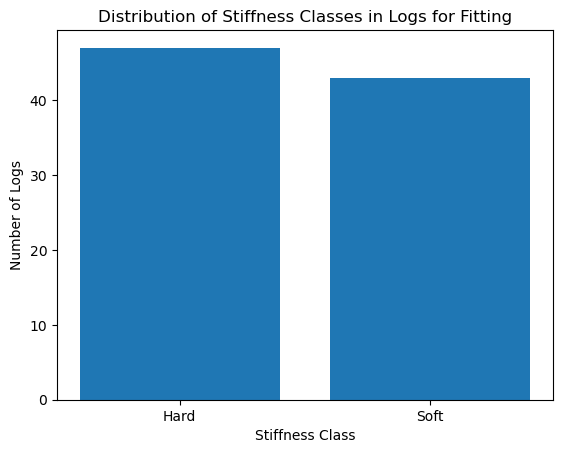

In [23]:
# visualize the distribution of stiffness classes in logs_fit
stiffness_counts = logs_fit['stiffness'].value_counts().sort_index()
import matplotlib.pyplot as plt
plt.bar(stiffness_counts.index, stiffness_counts.values)
plt.xlabel('Stiffness Class')
plt.ylabel('Number of Logs')
plt.title('Distribution of Stiffness Classes in Logs for Fitting')
plt.show()

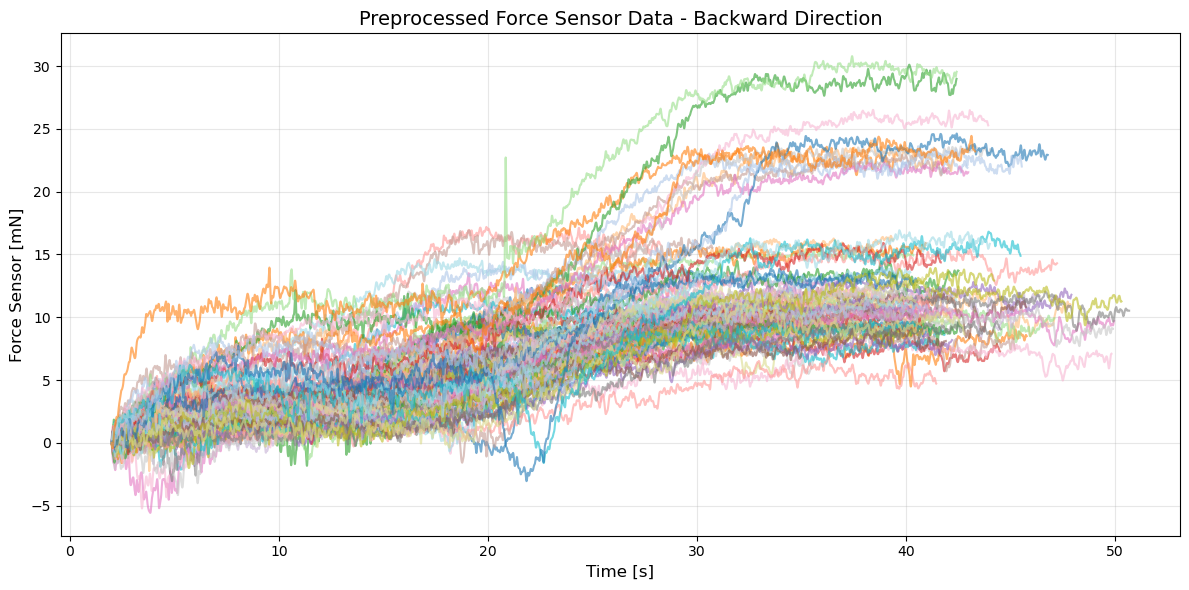

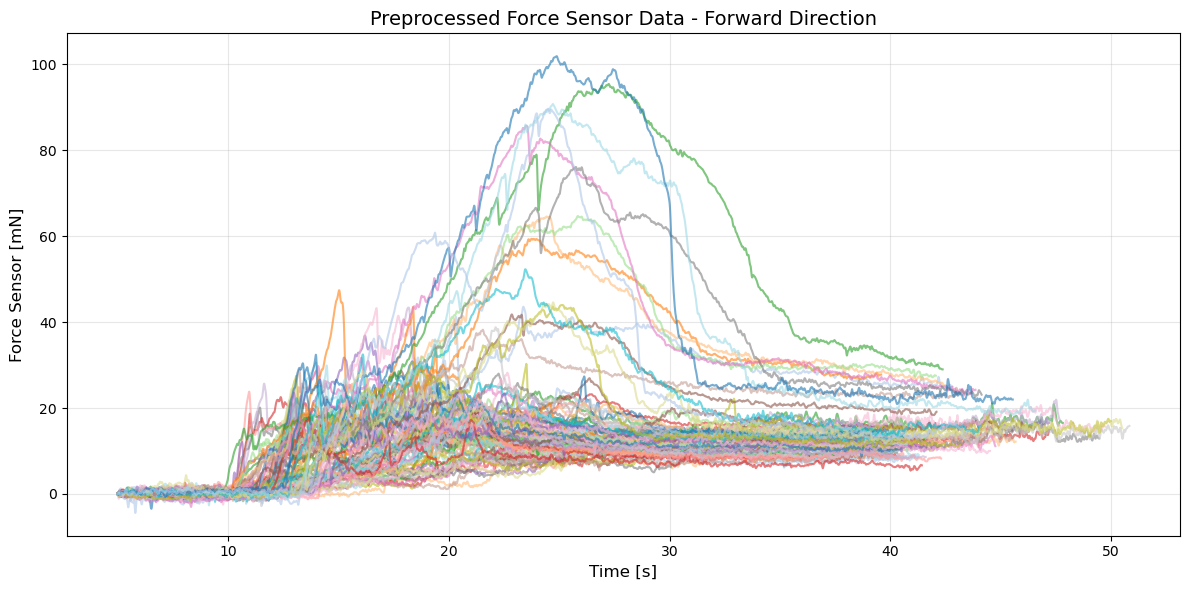

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine all curves into a single DataFrame for easier plotting
plot_data = []
for i, df in enumerate(data_fit_plot):
    df_plot = df.copy()
    df_plot['log_index'] = i
    df_plot['direction'] = logs_fit.loc[i, 'direction']
    df_plot['stiffness'] = logs_fit.loc[i, 'stiffness']
    plot_data.append(df_plot)
plot_df = pd.concat(plot_data, ignore_index=True)


for direction in ['Backward', 'Forward']:
    plt.figure(figsize=(12, 6))
    # Filter by direction
    dir_df = plot_df[plot_df['direction'] == direction]
    
    # Plot using sns.lineplot with alpha blending
    sns.lineplot(
        data=dir_df,
        x='timestamps',
        y='force_sensor_mN',
        hue='log_index',        # Different color per log
        palette='tab20',        # Color palette
        legend=False,           # Avoid huge legends
        alpha=0.6               # Transparency for overlapping curves
    )
    
    plt.title(f'Preprocessed Force Sensor Data - {direction} Direction', fontsize=14)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Force Sensor [mN]', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Models

## BK

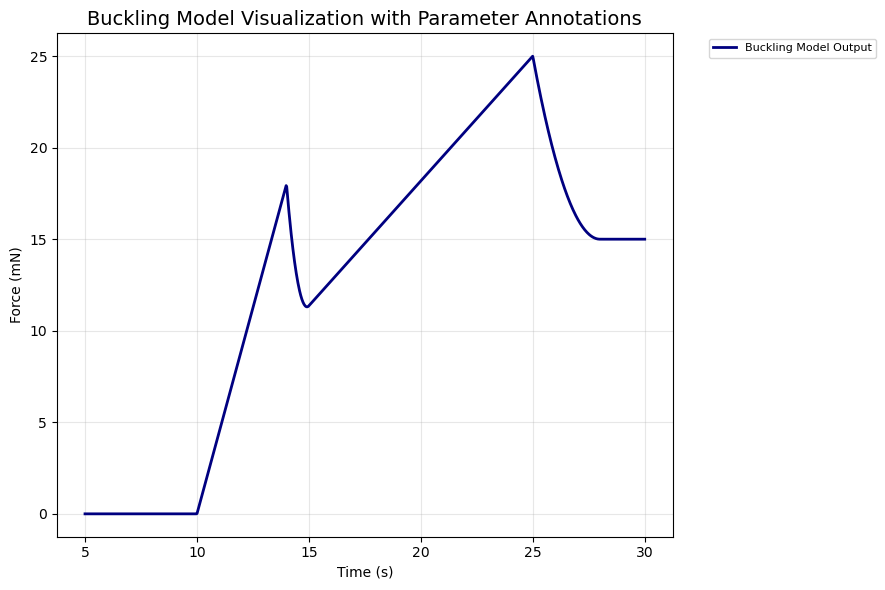

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from src.models.buckling_model import BucklingModel
from src.models.helpers import create_model_params


model_params = create_model_params()
xdata = [df["timestamps"].values for df in data_fit]
ydata = [df["force_sensor_mN"].values for df in data_fit] 
model_bk = BucklingModel(model_params, xdata, ydata)
x = np.linspace(5, 30, 1000)
params = (
    10, 25, 0, 15,   # x_start, x_end, y_start, y_end
    10, 10,           # f_pun_rise, f_pun_fall
    4, 8, 1,         # dx_rise, df_rise, k_rise
    1, 3             # dx_pun, dx_fall
)
y = model_bk.model_fun(x, params)
# Plot
plt.figure(figsize=(9, 6))
plt.plot(x, y, label='Buckling Model Output', color='navy', linewidth=2)

plt.title("Buckling Model Visualization with Parameter Annotations", fontsize=14)
plt.xlabel("Time (s)")
plt.ylabel("Force (mN)")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


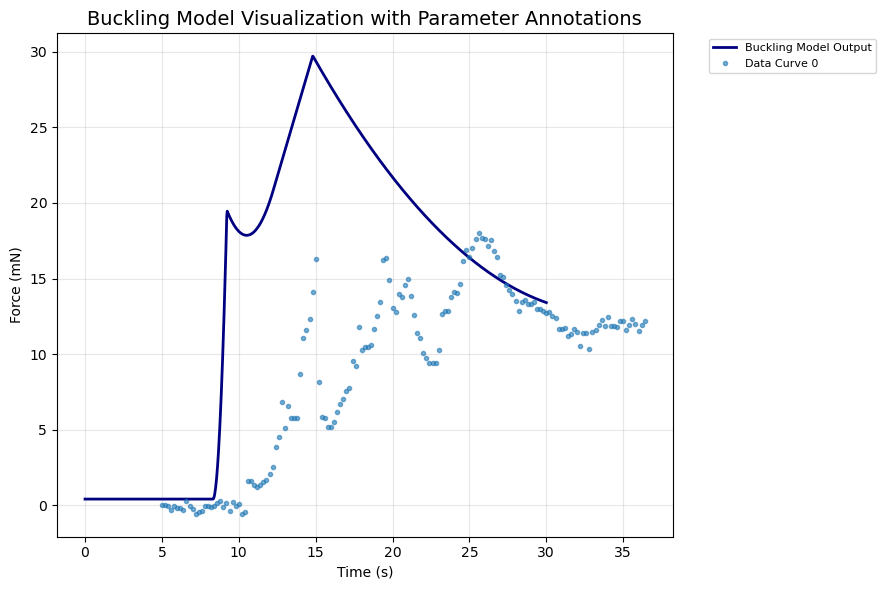

In [26]:
# # found params for curve 0 :    df_rise_0 0.9067
# wandb:    dx_fall_0 3.01458
# wandb:     dx_pun_0 18.95114
# wandb:    dx_rise_0 9.07795
# wandb: f_pun_fall_0 10.00768
# wandb: f_pun_rise_0 16.98367
# wandb:   final_loss 594.06662
# wandb:     k_rise_0 1.94737
# wandb:    train_sse 594.06662
# wandb:      x_end_0 14.81225
# wandb:    x_start_0 8.32205
# wandb:      y_end_0 12.73864
# wandb:    y_start_0 0.41775
found_params = (
    8.32205, 14.81225, 0.41775, 12.73864,   # x_start, x_end, y_start, y_end
    10.00768, 16.98367, 0.9067, 9.07795,   # f_pun_fall, f_pun_rise, dx_rise, df_rise
    1.94737, 3.01458, 18.95114  # k_rise, dx_fall, dx_pun
)

import numpy as np
import matplotlib.pyplot as plt
from src.models.buckling_model import BucklingModel
from src.models.helpers import create_model_params


model_params = create_model_params()
xdata = [df["timestamps"].values for df in data_fit]
ydata = [df["force_sensor_mN"].values for df in data_fit] 
model_bk = BucklingModel(model_params, xdata, ydata)
x = np.linspace(0, 30, 1000)

y = model_bk.model_fun(x, found_params)
# Plot
plt.figure(figsize=(9, 6))
plt.plot(x, y, label='Buckling Model Output', color='navy', linewidth=2)
plt.plot(xdata[0], ydata[0], 'o', label='Data Curve 0', markersize=3, alpha=0.6)
plt.title("Buckling Model Visualization with Parameter Annotations", fontsize=14)
plt.xlabel("Time (s)")
plt.ylabel("Force (mN)")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()